In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

## Data preprocessing of the dataset CIFAR-10

In [2]:
# @title Data preprocessing for Cifar-10 Dataset

batch_dir = "dataset/cifar-10-batches-py"
batches_meta_file = "dataset/cifar-10-batches-py/batches.meta"

def dump_batches():
    n_train_batches = 5
    
    for idx in range(1, n_train_batches + 1):
        labels, imgs = load_train_batch(batch_dir, idx)
        norm_imgs = normalize(imgs, 0.0, 255.0)
        encoded_labels = one_hot_encode(labels)
        
        file = 'dataset/prep/prep_batch_' + str(idx) + '.pickle'
        with open(file, 'wb') as f:
            pickle.dump((encoded_labels, norm_imgs), f)
    
    labels, imgs = load_test_batch(batch_dir)
    norm_imgs = normalize(imgs, 0.0, 255.0)
    encoded_labels = one_hot_encode(labels)
    
    file = 'dataset/prep/prep_test_batch.pickle'
    with open(file, 'wb') as f:
            pickle.dump((encoded_labels, norm_imgs), f)

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_train_batch(batch_dir, i):
    batch_i = unpickle(batch_dir + '/data_batch_' + str(i))
    labels = batch_i[b'labels']
    data = batch_i[b'data']
    imgs = data.reshape(len(data), 3, 32, 32).transpose(0,2,3,1)
    return labels, imgs

def load_test_batch(batch_dir):
    test_batch = unpickle(batch_dir + '/test_batch')
    labels = test_batch[b'labels']
    data = test_batch[b'data']
    imgs = data.reshape(len(data), 3, 32, 32).transpose(0,2,3,1)
    return labels, imgs
    

def load_labels():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def show_img(imgs, idx, labels, label_names):
    img = imgs[idx]
    label = np.argmax(labels[idx])
    category = label_names[label]
    print("Category of the image is {}".format(category))
    plt.imshow(img)
    
def normalize(x, min, max):
    return (x - min)/(max - min)

def one_hot_encode(x):
    encoded = np.zeros((len(x), 10))
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    return encoded

Category of the image is automobile


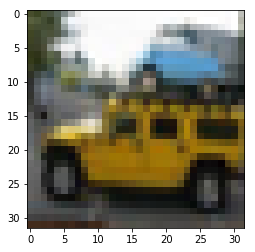

In [3]:
label_names = load_labels()
labels, imgs = load_train_batch(batch_dir, 1)
labels = one_hot_encode(labels)
norm_imgs = normalize(imgs, 0, 255.0)
show_img(norm_imgs, 9997, labels, label_names)

In [ ]:
dump_batches()

## Convolutional Neural Network

In [4]:
# Set of functions for the CNN architecture
def relu(x):
    return np.maximum(0, x)

def sigmoid(x, deriv=False):
    if deriv:
        return x * (1 - x)
    else:
        return 1 / (1 + np.e**-x)

Category of the image is frog


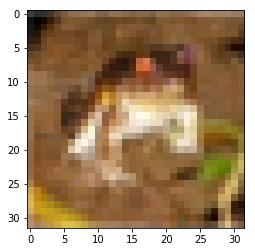

In [5]:
prep_batch_dir = 'dataset/prep'
batch_1 = prep_batch_dir + '/prep_batch_1.pickle'
with open(batch_1, 'rb') as f:
    batch_1_labels, batch_1_imgs = pickle.load(f, encoding='bytes')
    
show_img(batch_1_imgs, 0, batch_1_labels, label_names)

In [37]:
input_layer = batch_1_imgs[0]
kernel_size = 3
n_kernels = 1
stride = 1
padding = 0
kernel = np.zeros((kernel_size, kernel_size, 3)) + 0.01
row_kernel = kernel.reshape(1, -1)

## convolutional layer
n_pos_width = int(((input_layer.shape[0] - kernel_size + 2*padding)/stride) + 1)
n_pos_height = int(((input_layer.shape[1] - kernel_size + 2*padding)/stride) + 1)
print(n_pos_width, n_pos_height)

# create receptive fields of image and flat it to a 1-D vector
col_img = []
for height in range(0, n_pos_height):
    for width in range(0, n_pos_width):
        recept_field_red = input_layer[width:width+kernel_size, height:height+kernel_size, 0]
        recept_field_green = input_layer[width:width+kernel_size, height:height+kernel_size, 1]
        recept_field_blue = input_layer[width:width+kernel_size, height:height+kernel_size, 2]
        
        col_img.append([recept_field_red, recept_field_green, recept_field_blue])
col_img = np.asfarray(col_img).reshape((kernel_size**2)*3, -1)

feature_map = row_kernel.dot(col_img).reshape(n_pos_width, n_pos_height, n_kernels)
conv_layer = relu(feature_map)
conv_img = conv_layer.reshape(30, 30)

## pool layer
pool_size = 2
pool_pad = 0
pool_stride = 2
pool_n_pos_width = int(((conv_layer.shape[0] - pool_size + 2*pool_pad)/pool_stride) + 1)
pool_n_pos_height = int(((conv_layer.shape[1] - pool_size + 2*pool_pad)/pool_stride) + 1)

# max pooling
pool_layer = []
for height in range(0, pool_n_pos_height):
    for width in range(0, pool_n_pos_width):
        recept_field = conv_layer[width:width+pool_size, height:height+pool_size, 0]
        pool_layer.append(np.max(recept_field))
pool_layer = np.asfarray(pool_layer).reshape(pool_n_pos_width, pool_n_pos_height, 1)
pool_img = pool_layer.reshape(15, 15)

## Fully Connected Layers
# Hyper parameters
IN_NEURONS = pool_layer.shape[0] * pool_layer.shape[1] * pool_layer.shape[2]
HID_NEURONS = 100
OUT_NEURONS = 10
LEARNING_RATE = 0.2
EPOCHS = 4

target = batch_1_labels[0].reshape(-1, 1)
# Initialize weights with random values of a normal distribution
w_in_hid = np.random.normal(0.0, pow(HID_NEURONS, -1/2), (HID_NEURONS, IN_NEURONS))
w_hid_out = np.random.normal(0.0, pow(OUT_NEURONS, -1/2), (OUT_NEURONS, HID_NEURONS))


for e in range(EPOCHS):
fc_in_layer = pool_layer.reshape(IN_NEURONS, 1)
fc_hid_layer = sigmoid(w_in_hid.dot(fc_input_layer))
fc_out_layer = sigmoid(w_hid_out.dot(fc_hid_layer))

## Backpropagation
# Calculate error vector for each layer
error_out = target - fc_out_layer
error_hid = w_hid_out.T.dot(error_out)
error_in = w_in_hid.T.dot(error_hid)
# Calculate dL/dwjk
fc_out_layer_delta = error_out * sigmoid(fc_out_layer, deriv=True
# Calculate dL/dij
fc_hid_layer_delta = error_hid * sigmoid(fc_hid_layer, deriv=True)
# Update weights of each layer
w_hid_out += LEARNING_RATE * fc_out_layer_delta.dot(fc_hid_layer.T)
w_in_hid += LEARNING_RATE * fc_hid_layer_delta.dot(fc_in_layer.T)



30 30
6


## Visualizations of the Layers

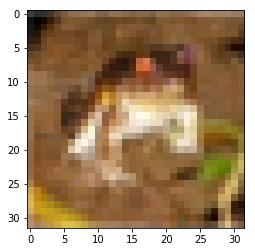

In [16]:
plt.imshow(input_layer)

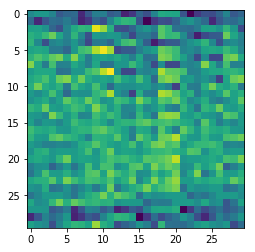

In [18]:
plt.imshow(conv_img)

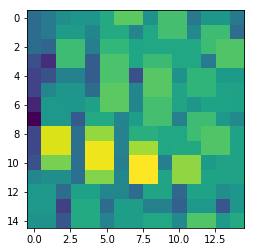

In [15]:
plt.imshow(pool_img)